In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms
import matplotlib.patches as patches

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm


import cv2
import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time
from torchvision.ops import nms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

In [ ]:
#Function to extract frames
def extractFrames(pathIn, pathOut):
   #directory path, where my video images will be stored
   os.mkdir(pathOut)
   #Capture video from video file
   cap = cv2.VideoCapture(pathIn)
#Counter Variable
   count = 0
   while (cap.isOpened()):
     # Capture frame-by-frame
     ret, frame = cap.read()
     if ret == True:
       # save frame as JPEG file
       cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)
       count += 1
     else:
       break
    # When everything done, release the capture
   cap.release()
   cv2.destroyAllWindows()

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bridges')

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/street.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/streets')

In [ ]:
extractFrames('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/ParlimentarySQ.mp4',
              '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/ParlimentarySQ')

In [ ]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)      

In [ ]:
rcnn = rcnn.eval()

In [ ]:
# COCO_INSTANCE_CATEGORY_NAMES
NAME = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
from PIL import Image
import glob

In [ ]:
Bridge_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bridges/*.jpg'):  ## using glob to pull all the image files in the bridge directory
    im=cv2.imread(filename)                                                                                
    Bridge_frames.append(im)

In [ ]:
Bridge_frames[0].shape ## shape of first image in bridges. all the images have same shape (3 represents colour if it's colour image which is RGB it gives 3)

In [ ]:
Bridge_frames[0] ## 720*1280 is same like a matrix shape 720 rows of lists and 1280 list in each of 720 rows. so, this is how images are read

In [ ]:
Street_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/streets/*.jpg'):
    im=cv2.imread(filename)
    Street_frames.append(im)

In [ ]:
ParlimentarySQ_frames = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/ParlimentarySQ/*.jpg'):
    im=cv2.imread(filename)
    ParlimentarySQ_frames.append(im)

In [ ]:
len(ParlimentarySQ_frames)

312

In [ ]:
from google.colab.patches import cv2_imshow
from matplotlib import pylab
from pylab import *

In [ ]:
## this is the function which takes raw image, only human labels and bounding boxes correspondng to those human labels with 0.925 of prediction score and IOU 1
## so get those images the function defined in next cell is helpful and it also runs this save_image funtion with little more plotting code to save images at the end of next funtion
def save_image(img,_box,_label,i):                           
  x1,y1,x2,y2 = _box[i]                                     
  _ = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255, 0), 2)  
  x_mid = int((x1+x2)/2)                                     
  y_mid = int(y1)                                            
  mid   = (x_mid,y_mid)                                       
  cv2.putText(img, _label[i], mid, cv2.FONT_HERSHEY_SIMPLEX,  
                   1, (255,255,255), 2, cv2.LINE_AA)
  return mid

In [ ]:
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

In [ ]:
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

In [ ]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
    rate = round((2*len(p1)/len(person))*100,2)
    cv2.putText(img, f'{rate}% not distant', (100,100), cv2.FONT_HERSHEY_SIMPLEX,  
                   2, (255,255,255), 2, cv2.LINE_AA) 
  return img

In [ ]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_streets')
os.mkdir('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_bridges')

In [ ]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_ParlimentarySQ')

In [ ]:
## So here we begin with our raw image, function takes image as input and IOU and min predictions score
dist_street = []
dist_frames = []
thresh=100
def model_pred(data,iou_threshold = 0.5,minimum_score = 0.9):
  count = 0 
                                                          ## count helps to increase image numbering while saving in folder
  for img in data:                                                     ## iterating each image from input data
    img1 = np.asarray(img)/220                                         ## converting image into array and dividing to 220 which can normalize array values
    img2 = torch.tensor(img1, dtype=torch.float32).permute((2,0,1))    ## as pytorch models only accept tensors and shape in specific way converting to tensors and chnaging shape t0 (3,720,1280)
    with torch.no_grad():                                              
      pred = rcnn([img2])                                               ## giving tensor array as input to model
    Labels = pred[0]['labels']                                           ## pred out put is a dictionary of boxes, albels and scores so takes them as separate lists
    Boxes = pred[0]['boxes']
    Scores = pred[0]['scores']
    ind = np.where(Labels==1)[0]                                          ## defining a variable which can search for labels with 1 which happens to humans
    person_label = Labels[ind]                                            ## taking labels which are 1
    person_boxes = Boxes[ind]                                              ## taking bounding boxes whose labels are 1
    person_scores = Scores[ind]                                           
    selected = nms(person_boxes, person_scores, iou_threshold).cpu().numpy()   
    _box = []                                                            
    _label = []
    for j in selected:                                
      if person_scores[j].item() > minimum_score:        ## this is to iterate BBoxes nad labels with high IOU and High predicted score and append to empty lists
        _label.append(NAME[person_label[j].item()])
        _box.append(person_boxes[j])                       
    midpoints = [save_image(img,_box,_label,i) for i in range(len(_label))]
    dist= compute_distance(midpoints,len(_box))
    p1,p2,d=find_closest(dist,len(_box),thresh)
    img = change_2_red(img,_box,p1,p2)
    plt.figure(figsize=(20,10))
    dist_street.append(img)
    status = cv2.imwrite(f'/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_ParlimentarySQ/rate{count}.png',img)
    count += 1                                                                
  return 

In [ ]:
model_pred(Bridge_frames)

In [ ]:
model_pred(Street_frames)

In [ ]:
model_pred(ParlimentarySQ_frames)

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_streets/'
pathOut = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/streets_rate.avi'
array_frames = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(re.sub('\D', '', x)))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    array_frames.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 25.05, size)
for i in range(len(array_frames)):
    out.write(array_frames[i])
out.release()

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_bridges/'
pathOut = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/bridges_rate.avi'
array_frames = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(re.sub('\D', '', x)))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    array_frames.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 24, size)
for i in range(len(array_frames)):
    # writing to a image array
    out.write(array_frames[i])
out.release()

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/my_ParlimentarySQ/'
pathOut = '/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/ParlimentarySQ_rate.avi'
array_frames = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: int(re.sub('\D', '', x)))

for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    array_frames.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 25.05, size)
for i in range(len(array_frames)):
    out.write(array_frames[i])
out.release()

### **Process Explanation:**

Though we are using a Restnet_50_fpn faster RCNN model to predict the labels and bounding boxes of our data, because of the extensive ability to detect many objects, pretrained models are capable of detecting few SHADOWS as Humans and also not detecting overlapping humans.

To deal with these problems we have worked on predicted scores and IOU index using NON-Max Supression.

We observed that real humans predicted by the model are having high scores closer to 1 and shadows are having lesser scores. But there is another case where a real human and his shadow are considered as  one object this couldn't be solved by changing IOU index or fixing minimum socre high.

Coming to overlapping Increasing Interest over Union index means calculating ratio of area of interest to area of union of two adjacent bounding boxes, if the ratio is greater than the value we set then the bounding box with lesser contribution to intersection compared to it's whole area is avoided. And this is done using NMS funtion in pytorch. 

As this approach could solve the problem to some extent but we are still facing few prolems as the data is so miscellaneous.

We thought of few other approaches to avoid this problem for a better level of prediction.

One approach is to training a backbone network on our own data by manually creating bounding boxes and labels (which has it's own difficulties explained in other notebook)

The other approach is to apply a better filtering of bounding boxes of real huamns by applying different models which can predict huamns better or using the same model.

Below are the plots of few images where you can witness above mentioned problems.


### Adjusting IOU and Predicted Score for better Results:


In [ ]:
from PIL import Image
import glob
Bridge_images = []
for filename in glob.glob('/content/drive/My Drive/Colab Notebooks/Social Distancing Tool/Bridge/*.jpg'):
    im=Image.open(filename)
    Bridge_images.append(im)

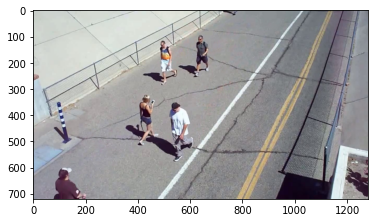

In [ ]:
plt.imshow(Bridge_images[45])

In [ ]:
img1 = np.asarray(Bridge_images[45])/200                                        ## converting image into array and dividing to 220 which can normalize array values
img2 = torch.tensor(img1, dtype=torch.float32).permute((2,0,1))    ## as pytorch models only accept tensors and shape inspecific way converting to tensors and chnaging shape t0 (3,720,1280)
with torch.no_grad():                                            
  pred = rcnn([img2])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
import matplotlib.patches as patches
def plotDetection(ax, abs_pos, label=None):
    x1, y1, x2, y2 = abs_pos
    
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

In [ ]:
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots(1)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()

Two functions are adopted from deep learning Object Detection Lecture.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


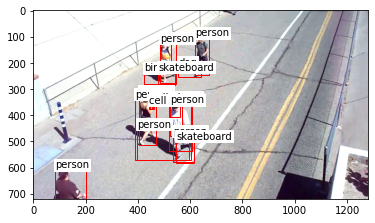

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=1, min_score=0, label_names=NAME) ## setting IOU high and mini score to very low

In the above method implemented, we are using IOU index as 1 and minimum score as 0 which results in all the objects with no minimum score and which also have 100% overlap with person objects like skateboard, cellphone.

We can avoid this by adjusting IOU to minimum and shortlisting only humans with high prediction score.

First we are applying high score and low IOU index.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


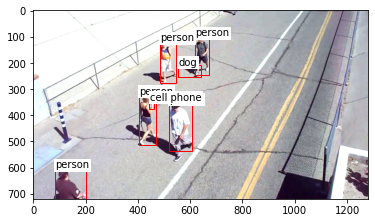

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.1, min_score=0, label_names=NAME) 

Even in above case if we reduce IOU by big margin and set minimum score as very low, model predicts objects like cellphones. To avoid this we have two solutions,that is to increase Min Score or we can just plot objects with humans(this is done in the later part).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


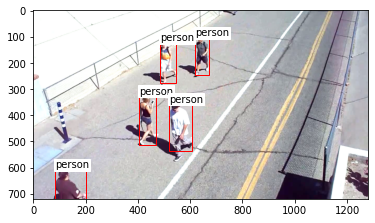

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.1, min_score=0.9, label_names=NAME)

Here we got rid of all other objects and only left with real humans. By setting minimum score very high, we observed real humans only have higher predicted scores.

Using same conditions on some other image to check if it works fine with overlapping, by taking image with overlapping.

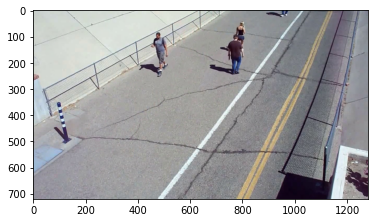

In [ ]:
plt.imshow(Bridge_images[205])

In [ ]:
img1 = np.asarray(Bridge_images[205])/200                          
img2 = torch.tensor(img1, dtype=torch.float32).permute((2,0,1))    
with torch.no_grad():                                            
  pred = rcnn([img2])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


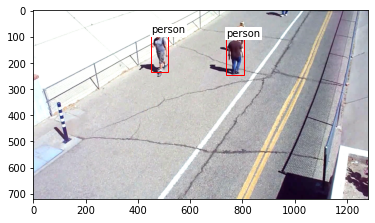

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.1, min_score=0.9, label_names=NAME)

So here the problem is, till now, when we did not have images with real humans overlapping and hence it's prediction was good. But, when I gave an overlapping image input, it failed to predict the person overlapping. So, with low value of IOU index we fail to predict overlapping humans. Now we are trying to increase IOU to the point where it can also predict overlapping real humans.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


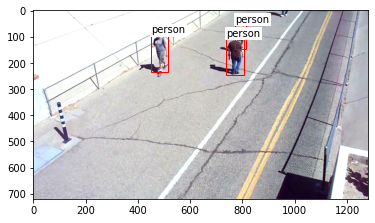

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.5, min_score=0.9, label_names=NAME)

Now we are applying on other images to check this value of IOU and minimun score works.

In [ ]:
img1 = np.asarray(Bridge_images[102])/200                                       
img2 = torch.tensor(img1, dtype=torch.float32).permute((2,0,1))    
with torch.no_grad():                                           
  pred = rcnn([img2])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


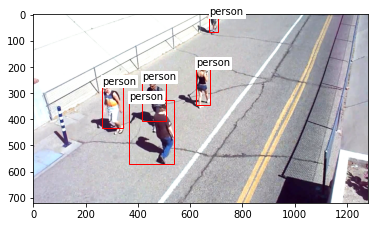

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.5, min_score=0.9, label_names=NAME)

It works well on this image.

In [ ]:
img1 = np.asarray(Bridge_images[330])/200                                       
img2 = torch.tensor(img1, dtype=torch.float32).permute((2,0,1))   
with torch.no_grad():                                            
  pred = rcnn([img2])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


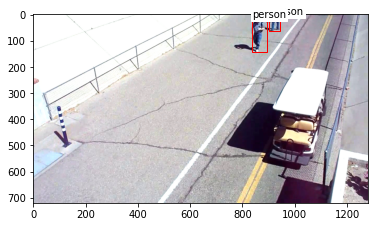

In [ ]:
showPreds(img2, pred[0], iou_max_overlap=0.5, min_score=0.9, label_names=NAME)